**Mounting Google Drive and changing directory**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd '/content/drive/My Drive/101getrekt'

/content/drive/My Drive/101getrekt


## Download and Explore the Dataset

In [0]:
!unzip -qq -n data/dataset-original.zip -d data/dataset-original


In [0]:
pip install split-folders tqdm

In [0]:
import split_folders

In [0]:
!mkdir data/output

In [0]:
split_folders.ratio('/content/drive/My Drive/101getrekt/data/dataset-original/dataset-original', output="/content/drive/My Drive/101getrekt/data/output", seed=1337, ratio=(.6, .2, .2)) # default values


Copying files: 2527 files [01:19, 31.67 files/s]


In [0]:
import os

base_dir = 'data/output'

# Directory to our training data
train_folder = os.path.join(base_dir, 'train')

# Directory to our validation data
val_folder = os.path.join(base_dir, 'val')

Now, let's find out the total number of images we have in each `train`, `val` and `test`.

In [4]:
# List folders and number of files
print("Directory, Number of files")
for root, subdirs, files in os.walk(train_folder):
    print(root, len(files))

Directory, Number of files
data/output/train 0
data/output/train/cardboard 241
data/output/train/glass 300
data/output/train/metal 246
data/output/train/paper 356
data/output/train/plastic 289
data/output/train/trash 82


We can see that there are 6 categories/folders in each `train` and `val` folder.

Now let's take a look at a few images to get a better sense of what the categories look like.


In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 KoreanHeart and 8 KungfuCrane poses. You can rerun the cell to see a new batch.

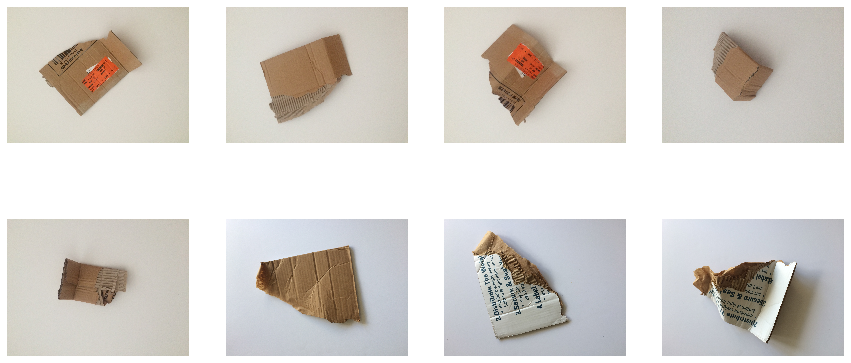

In [15]:
train_cardboard_dir= "data/output/train/cardboard"
train_cardboard_fnames = os.listdir(train_cardboard_dir)


# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(15, 15)

pic_index += 8
next_cardboard_pix = [os.path.join(train_cardboard_dir, fname) 
                for fname in train_cardboard_fnames[pic_index-8:pic_index]]


for i, img_path in enumerate(next_cardboard_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

## Data Preprocessing

Let's set up data generators that will read images from our source folders and convert them to float32 tensors. We'll have one generator for each training and validation folders.

### Batch
Our generators will yield batches of `32` images of size `299 x 299` and their labels.

### Feature scaling
Recall that in our MNIST/CIFAR-10 exercises, data that goes into a neural network should be normalised in a way that is easier to be processed by the network. In our case, we will preprocess our images by normalising the pixels values to be in the 0 to 1 range. This happens by dividing each pixel value by 255 and this process is known as data normalisation or rescaling.

### Generator - ImageDataGenerator
To rescale the data, we use `keras.preprocessing.image.ImageDataGenerator` class with the `rescale` parameter. This class will also allow us to instantiate generators of augmented image batches (and their labels) via `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs such as `fit_generator`, `evaluate_generator` and `predict_generator`. We used data augmentation for the training image generator. To find out more about how to do image augmentation in keras, go [here](https://keras.io/preprocessing/image/).

**Defining Random Eraser**

In [0]:
import numpy as np


def get_random_eraser(p=0.5, s_l=0.02, s_h=0.1, r_1=0.1, r_2=1/0.1, v_l=0, v_h=1, pixel_level=True):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [6]:
from keras.preprocessing.image import ImageDataGenerator

# Batch size
bs = 32

# All images will be resized to this value
image_size = (299, 299)

# All images will be rescaled by 1./255. We apply data augmentation here.
train_datagen = ImageDataGenerator(rescale=1./255,
                                   brightness_range= [0.5,1.5],
                                   horizontal_flip=True,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest',
                                   preprocessing_function=get_random_eraser(v_l=0, v_h=1),)

val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
print(train_folder)
print("Preparing generator for train dataset")
train_generator = train_datagen.flow_from_directory(
    directory= train_folder, # This is the source directory for training images 
    target_size=image_size, # All images will be resized to value set in image_size
    batch_size=bs,
    class_mode='categorical')

# Flow validation images in batches of 32 using val_datagen generator
print("Preparing generator for validation dataset")
val_generator = val_datagen.flow_from_directory(
    directory= val_folder, 
    target_size=image_size,
    batch_size=bs,
    class_mode='categorical')

Using TensorFlow backend.


data/output/train
Preparing generator for train dataset
Found 1514 images belonging to 6 classes.
Preparing generator for validation dataset
Found 503 images belonging to 6 classes.


**Importing Pre-trained model and adding FCN layers**

Freeze all layers

In [0]:
from keras.applications.xception import Xception
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, MaxPooling2D
from keras import backend as K
from keras import regularizers

Xcep = Xception(weights='imagenet', include_top=False)

x = Xcep.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024,activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(inputs = Xcep.input, outputs=predictions)

for layer in Xcep.layers:
  layer.trainable = False
  
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

## Setting Up Checkpoints

Let's setup a [checkpoint](https://keras.io/callbacks/) to help us monitor the validation accuracy as the model trains. This checkpoint will save the model with best validation accuracy seen so far.

In [0]:
from keras.callbacks import ModelCheckpoint

bestValidationCheckpointer = ModelCheckpoint('xception_v2_finetuned.hdf5', monitor='val_acc', save_best_only=True, verbose=1)

In [8]:
from keras.models import load_model

model = load_model('/content/drive/My Drive/101getrekt/xception_v2.hdf5')
model.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
_________________________________________________________________

Train till it stagnates (~10epochs)

In [0]:
history = model.fit_generator(
        train_generator, # train generator has 973 train images
        steps_per_epoch=train_generator.samples // bs + 1,
        epochs=10,
        validation_data=val_generator, # validation generator has 253 validation images
        validation_steps=val_generator.samples // bs + 1,
        callbacks=[bestValidationCheckpointer]
)

Epoch 1/10
48/48 [==============================] - 352s 7s/step - loss: 7.8805 - acc: 0.4382 - val_loss: 3.5650 - val_acc: 0.5805

Epoch 00001: val_acc improved from -inf to 0.58052, saving model to xception_v2.hdf5
Epoch 2/10
48/48 [==============================] - 287s 6s/step - loss: 2.8639 - acc: 0.5592 - val_loss: 2.2085 - val_acc: 0.5408

Epoch 00002: val_acc did not improve from 0.58052
Epoch 3/10
48/48 [==============================] - 317s 7s/step - loss: 1.8894 - acc: 0.6071 - val_loss: 1.3232 - val_acc: 0.7396

Epoch 00003: val_acc improved from 0.58052 to 0.73956, saving model to xception_v2.hdf5
Epoch 4/10
48/48 [==============================] - 318s 7s/step - loss: 1.6782 - acc: 0.6094 - val_loss: 1.2740 - val_acc: 0.7455

Epoch 00004: val_acc improved from 0.73956 to 0.74553, saving model to xception_v2.hdf5
Epoch 5/10
48/48 [==============================] - 318s 7s/step - loss: 1.5277 - acc: 0.6201 - val_loss: 1.1640 - val_acc: 0.7157

Epoch 00005: val_acc did not 

In [9]:
for i, layer in enumerate(model.layers):
  print(i, layer.name)

0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_5
13 block2_pool
14 batch_normalization_5
15 add_13
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_6
23 block3_pool
24 batch_normalization_6
25 add_14
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_7
33 block4_pool
34 batch_normalization_7
35 add_15
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_16
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_se

Load model(optional - no need if continuing from previous training)

In [0]:
from keras.models import load_model
import time

st= time.time()

model_path = 'DIXInR_0.845.hdf5'
model = load_model( model_path )
print('Time taken: ' + str(time.time()-st))

**Unfreezing Layers** (2/3)

In [0]:
for layer in model.layers[:56]:
  layer.trainable = False
for layer in model.layers[56:]:
  layer.trainable = True

Let's summarise the model architecture:

In [11]:
import pandas as pd

layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])  

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_2,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,False
2,<keras.layers.normalization.BatchNormalization...,block1_conv1_bn,False
3,<keras.layers.core.Activation object at 0x7fa7...,block1_conv1_act,False
4,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,False
...,...,...,...
131,<keras.layers.core.Activation object at 0x7fa7...,block14_sepconv2_act,True
132,<keras.layers.pooling.GlobalAveragePooling2D o...,global_average_pooling2d_2,True
133,<keras.layers.core.Dense object at 0x7fa776679...,dense_3,True
134,<keras.layers.core.Dropout object at 0x7fa7766...,dropout_2,True


**Change Optimizer**

We train our model with `categorical_crossentropy` loss, because this is a multi-class problem. We will use the `adam` optimizer with default settings. During training, we want to monitor `accuracy` of the classification.

In [0]:
from keras.optimizers import SGD

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Model Training 


In [13]:
history = model.fit_generator(
        train_generator, # train generator has 973 train images
        steps_per_epoch=train_generator.samples // bs + 1,
        epochs=50,
        validation_data=val_generator, # validation generator has 253 validation images
        validation_steps=val_generator.samples // bs + 1,
        callbacks=[bestValidationCheckpointer]
)

Epoch 1/50
48/48 [==============================] - 1150s 24s/step - loss: 1.0260 - acc: 0.7424 - val_loss: 0.9812 - val_acc: 0.7376

Epoch 00001: val_acc improved from -inf to 0.73757, saving model to xception_v2_finetuned.hdf5
Epoch 2/50
48/48 [==============================] - 279s 6s/step - loss: 0.6355 - acc: 0.8409 - val_loss: 1.4848 - val_acc: 0.6978

Epoch 00002: val_acc did not improve from 0.73757
Epoch 3/50
48/48 [==============================] - 322s 7s/step - loss: 0.5497 - acc: 0.8683 - val_loss: 1.0155 - val_acc: 0.7316

Epoch 00003: val_acc did not improve from 0.73757
Epoch 4/50
48/48 [==============================] - 323s 7s/step - loss: 0.4563 - acc: 0.8962 - val_loss: 0.6485 - val_acc: 0.8171

Epoch 00004: val_acc improved from 0.73757 to 0.81710, saving model to xception_v2_finetuned.hdf5
Epoch 5/50
48/48 [==============================] - 323s 7s/step - loss: 0.3921 - acc: 0.9081 - val_loss: 1.7939 - val_acc: 0.6203

Epoch 00005: val_acc did not improve from 0.8

KeyboardInterrupt: ignored

**Plotting Graph**

In [16]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

NameError: ignored

In [22]:
import cv2
import numpy as np

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

image_path='/content/drive/My Drive/101getrekt/data/output/test/cardboard/cardboard149.jpg'

def predict_class(image_path):
  labels = ['cardboard','glass','metal','paper','plastic','trash']
  img = cv2.imread(image_path)
  img = cv2.resize(img,(299,299))
  img = np.reshape(img,[1,299,299,3])
  img = img / 255

  classes = model.predict(img)
  predicted_class= np.argmax(classes[0])
  return labels[predicted_class]

predict_class(image_path)

'cardboard'